# Spatial subsetting with a GeoTIFF file

This notebook demonstrates usage of the `spatial_subset_geotiff` WPS process, with additional visualisation of the output.

In [1]:
# Note: Version pinning required to work around https://github.com/matplotlib/basemap/issues/435
# <This issue should be resolved upon release of matplotlib==3.0.2>

In [ ]:
!conda install -f -y \
    basemap=1.2.0 \
    matplotlib=3.0.0

## Importing packages

In [3]:
import owslib.wps
import urllib.request
from io import BytesIO
from zipfile import ZipFile
import base64
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

## Accessing the WPS server
The URL of the server is the only required piece of information to initialise the WPS object.
This object will be used later to communicate with the WPS server.

In [4]:
wps_server_url = "https://wps.test.ecocloud.org.au/wps"
wps = owslib.wps.WebProcessingService(wps_server_url)

## Finding out about the `spatial_subset_geotiff` WPS process
As WPS processes are able to describe themselves, you can run the following to find out what inputs and outputs it has. This is completely optional - you can skip this if you already have advance knowledge of the process.

In [5]:
from IPython.display import display, HTML
import pandas as pd

process_name = "spatial_subset_geotiff"
description = wps.describeprocess(process_name)

# Describes the process
process_info = [
    ["Identifier", description.identifier],
    ["Title", description.title],
    ["Abstract", description.abstract],
]

display(HTML("<h3>Process information</h3>"))
display(pd.DataFrame(process_info, columns=["", ""]))

# Describes inputs to the process
process_inputs = []
for data_input in description.dataInputs:
    process_inputs.append([data_input.identifier, data_input.title])

display(HTML("<h3>Process inputs</h3>"))
display(pd.DataFrame(process_inputs, columns=["Parameter", "Title"]))


# Describes outputs of the process
process_outputs = []
for process_output in description.processOutputs:
    process_outputs.append([process_output.identifier, process_output.title])

display(HTML("<h3>Process outputs</h3>"))
display(pd.DataFrame(process_outputs, columns=["Parameter", "Title"]))

,,
0,Identifier,spatial_subset_geotiff
1,Title,GeoTIFF data spatial subset
2,Abstract,Subsets a given GeoTIFF file with given spatia...


,Parameter,Title
0,file,GeoTIFF file
1,shapefile,.zip file representing ESRI Shapefile of geome...


,Parameter,Title
0,output,Metadata


## Getting the data we want to use
We will be fetching sample data from the BCCVL and extract a GeoTIFF file from the ZIP file.

In this example, we read the contents of the GeoTIFF data file and encode it as [Base64](https://en.wikipedia.org/wiki/Base64). This encoded data is then included in the WPS request and uploaded to the server later.

In [6]:
# Australia, current climate (1976-2005), 30 arcsec (~1 km)
datafile_url = "https://app.bccvl.org.au/datasets/climate/australia/australia_1km/current.76to05.zip/@@download/current.76to05.zip"

# Download and extract the particular GeoTIFF file we want (Annual precipitation)
with urllib.request.urlopen(datafile_url) as response:
    with ZipFile(BytesIO(response.read())) as datafile_archive:
        datafile_base64 = base64.b64encode(datafile_archive.read("current.76to05/data/bioclim_12.tif")).decode("utf-8")

## Constructing the WPS request
The input parameters of the request to the `spatial_subset_geotiff` process are bundled in a list of tuples as below.

The shape geometry we are using for the subsetting is that representing the area of Queensland.

You may notice `ComplexDataInput()` being used for the `file` and `shapefile` inputs - the WPS process expects "complex" data inputs for these, and these are generally found for references to data or binary files.

In [7]:
shapefile_url = "http://spatial.ala.org.au/ws/shape/shp/3742606"

inputs = [
    ("file", owslib.wps.ComplexDataInput(datafile_base64, mimeType="image/tiff", encoding="base64")),
    ("shapefile", owslib.wps.ComplexDataInput(shapefile_url)),
]

## Executing the WPS request
Execution involves simply handing off the input to the WPS server and telling it which process to run it under.

We also tell the `execute()` method that the output we expect is named `output` and the execution mode is asynchronous (`ASYNC`) which requires us to check back with the server to find out when the request has been completed.

This check is done in the next cell - a loop runs until the request is complete, with a check occurring every 5 seconds.

In [8]:
process_name = "spatial_subset_geotiff"
request = wps.execute(process_name, inputs, output="output", mode=owslib.wps.ASYNC)

In [9]:
# Loop checks status every 5 seconds
while not request.isComplete():
    request.checkStatus(sleepSecs=5)

# Once we are done...
print("Done")

Done


## Retrieving the output
Once the WPS server is done, the URL to the output is provided and can be used to download the output NetCDF file.

In [10]:
output_url = request.processOutputs[0].reference
file_path, _ = urllib.request.urlretrieve(output_url)

## Reading the output
We read out some of the metadata from the GeoTIFF file to understand what area it covers before plotting.

In [11]:
# Open file
dataset = gdal.Open(file_path)
image_array_data = dataset.GetRasterBand(1).ReadAsArray().T

x0, dx, dxdy, y0, dydx, dy = dataset.GetGeoTransform()
nx = dataset.RasterXSize
ny = dataset.RasterYSize

# Geographical extent of file
xmin = x0 + dx * 0.5
xmax = x0 + (dx * nx) - dx * 0.5
ymin = y0 + (dy * ny) + dy * 0.5
ymax = y0 - dy * 0.5

## Visualising the output
For the example data here, we can present it on a map of Australia as shown below.

In [12]:
# Create map around Australia
map = Basemap(projection='merc',llcrnrlat=-45,urcrnrlat=-9,llcrnrlon=111,urcrnrlon=155,resolution='l')

In [14]:
# Map longitude and latitude into plot domain
lons,lats = np.mgrid[xmin:xmax+dx:dx, ymax+dy:ymin:dy]
x,y = map(lons,lats)

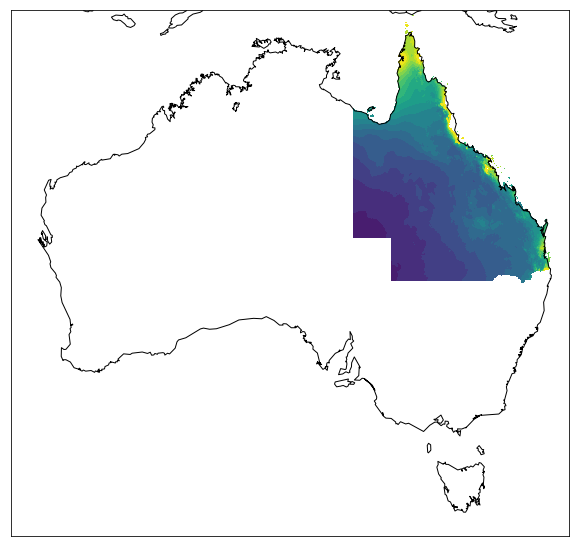

In [15]:
# Plot
plt.figure(figsize=(10,10))
map.drawcoastlines()
map.drawcountries()
map.contourf(x,y,image_array_data,levels=np.arange(0,2000,100))
plt.show()